In [1]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from itf import iTransformer
from itf_utils import Dataset_hour, train
from argparse import Namespace
import random

In [2]:
# reset seed 
def all_seed(seed=6666):
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')
    
    
all_seed(202403)

Set env random_seed = 202403


# 1. loading data 
- long term forcast
- data: [ETT-small](https://github.com/zhouhaoyi/ETDataset/tree/main)

In [3]:
data_dir = "/home/scc/Downloads/Datas/ETDataset/ETT-small"
data_file = f'{data_dir}{os.sep}ETTh2.csv'
data_file = f'{data_dir}{os.sep}ETTh1.csv'
df = pd.read_csv(data_file)
df = df.sort_values(by='date', ignore_index=True)
print(df.shape)
df.head()

(17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [4]:
base_ = 30 * 24
seq_len = 96
border1s = [0, 12 * base_ - seq_len, (12 + 4) * base_ - seq_len]
border2s = [12 * base_, (12 + 4) * base_, (12 + 8) * base_]
list(zip(border1s, border2s))

[(0, 8640), (8544, 11520), (11424, 14400)]

# dataloader

In [5]:
cfg = Namespace(
    task_name='long_term_forecast',
    output_attention=False,
    # enc param: embed & attention
    use_norm=True,
    d_model=512,
    d_ff=512,
    n_heads=16, #8,
    dropout=0.15,
    e_layers=2,
    activation='gelu',
    # seq param
    seq_len=4*7*24,
    pred_len=24, 
    learning_rate=1.0e-4, #5e-6,
    num_epochs=20,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='./models_pt'
)
target_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

In [6]:
# df.columns

In [7]:
tr_data_set = Dataset_hour(df, target_cols=target_cols, flag='train', seq_len=cfg.seq_len, pred_len=cfg.pred_len, scale=True)
tr_loader = DataLoader(tr_data_set, batch_size=cfg.batch_size, shuffle=True)
print(len(tr_data_set))

val_data_set = Dataset_hour(df, target_cols=target_cols, flag='val', seq_len=cfg.seq_len, pred_len=cfg.pred_len, scale=True)
val_loader = DataLoader(val_data_set, batch_size=cfg.batch_size, shuffle=True)
print(len(val_data_set))

te_data_set = Dataset_hour(df, target_cols=target_cols, flag='test', seq_len=cfg.seq_len, pred_len=cfg.pred_len, scale=True)
test_loader = DataLoader(te_data_set, batch_size=cfg.batch_size, shuffle=False)
print(len(te_data_set))

set_type(0): 0 -> 8640 len=7945
df_raw.shape=(17420, 8) data.shape=(17420, 7) self.data_x.shape=(8640, 7)
7945
set_type(1): 7968 -> 11520 len=2857
df_raw.shape=(17420, 8) data.shape=(17420, 7) self.data_x.shape=(3552, 7)
2857
set_type(2): 10848 -> 14400 len=2857
df_raw.shape=(17420, 8) data.shape=(17420, 7) self.data_x.shape=(3552, 7)
2857


# train

In [8]:
itf_model = iTransformer(cfg)

In [9]:
itf_model = train(
    itf_model, tr_loader, val_loader, test_loader, cfg, invert_tf=te_data_set.inverse_transform
)

/home/scc/anaconda3/envs/LLM/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001, Steps: 249 | Train Loss: 0.32809(invLoss: 5.11133) Vali Loss: 0.50701 Test Loss: 0.34175
Saved Best Model: loss=0.50701
Epoch: 002, Steps: 249 | Train Loss: 0.25336(invLoss: 3.99947) Vali Loss: 0.47596 Test Loss: 0.34163
Saved Best Model: loss=0.47596
Epoch: 003, Steps: 249 | Train Loss: 0.20759(invLoss: 3.35810) Vali Loss: 0.52578 Test Loss: 0.35098
Epoch: 004, Steps: 249 | Train Loss: 0.17568(invLoss: 2.79653) Vali Loss: 0.52857 Test Loss: 0.35355
Epoch: 005, Steps: 249 | Train Loss: 0.15405(invLoss: 2.41727) Vali Loss: 0.50837 Test Loss: 0.35723
Epoch: 006, Steps: 249 | Train Loss: 0.13650(invLoss: 2.11861) Vali Loss: 0.52463 Test Loss: 0.35747
Epoch: 007, Steps: 249 | Train Loss: 0.12430(invLoss: 1.90331) Vali Loss: 0.52491 Test Loss: 0.36321
Epoch: 008, Steps: 249 | Train Loss: 0.11465(invLoss: 1.73443) Vali Loss: 0.51360 Test Loss: 0.36423
Epoch: 009, Steps: 249 | Train Loss: 0.10718(invLoss: 1.61777) Vali Loss: 0.50440 Test Loss: 0.35833
Epoch: 010, Steps: 249 | Trai

# inference 

In [10]:
print(len(test_loader))
i_set = 24 #24 #48
device = cfg.device
itf_model.eval()
with torch.no_grad():
    for i, (batch_x, batch_y, seq_x_mark, seq_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        seq_x_mark = seq_x_mark.float().to(device)
        seq_y_mark = seq_y_mark.float().to(device)

        outputs = itf_model(batch_x, seq_x_mark)
        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()
        if i == i_set:
            print(i)
            break

90
24


In [11]:
# df[:48].set_index('date')['OT'].plot()

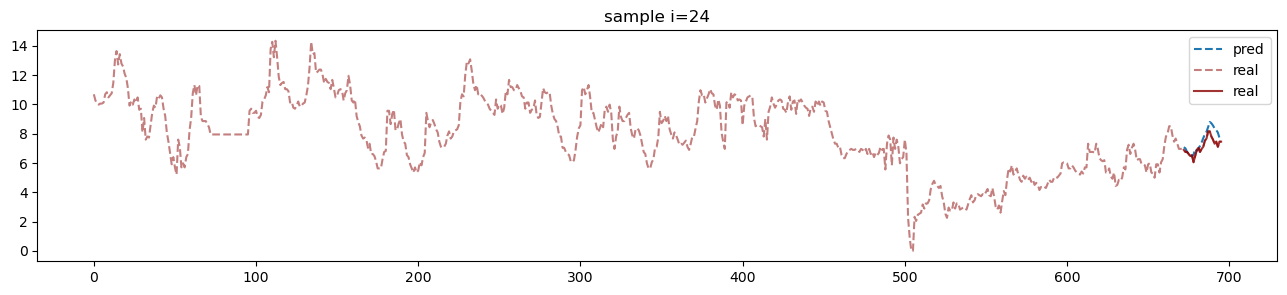

In [12]:
import matplotlib.pyplot as plt


for b in range(pred.shape[0]):
    plt.figure(figsize=(16, 3))
    back_seq = tr_data_set.inverse_transform(batch_x[b].detach().cpu().numpy())[:, -1].flatten()
    pred_ = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(pred[b].numpy())[:, -1].flatten()])
    real_only = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])
    real_ = np.concatenate([back_seq, tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])

    plt.plot(pred_, label='pred', linestyle='--')
    plt.plot(real_, label='real', linestyle='--', color='darkred', alpha=0.5)
    plt.plot(real_only, label='real', color='darkred', alpha=0.8)
    plt.legend()
    plt.title(f'sample i={i_set}')
    plt.show()
    break
    # if b >= 3:
    #     break

# ITF add dec_date_ information
- 周期性较强的时候加这个特征会有效

In [13]:
cfg.x_mark_dec_flag = True
cfg.learning_rate = 2.5e-5
itf_model_new = iTransformer(cfg)
itf_model_new = train(
    itf_model_new, tr_loader, val_loader, test_loader, cfg, invert_tf=te_data_set.inverse_transform
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001, Steps: 249 | Train Loss: 0.41234(invLoss: 6.55387) Vali Loss: 0.61732 Test Loss: 0.36858
Saved Best Model: loss=0.61732
Epoch: 002, Steps: 249 | Train Loss: 0.31255(invLoss: 4.78342) Vali Loss: 0.53691 Test Loss: 0.34843
Saved Best Model: loss=0.53691
Epoch: 003, Steps: 249 | Train Loss: 0.28606(invLoss: 4.37994) Vali Loss: 0.51198 Test Loss: 0.34263
Saved Best Model: loss=0.51198
Epoch: 004, Steps: 249 | Train Loss: 0.26926(invLoss: 4.15592) Vali Loss: 0.50442 Test Loss: 0.34024
Saved Best Model: loss=0.50442
Epoch: 005, Steps: 249 | Train Loss: 0.25392(invLoss: 3.95396) Vali Loss: 0.48942 Test Loss: 0.34193
Saved Best Model: loss=0.48942
Epoch: 006, Steps: 249 | Train Loss: 0.23752(invLoss: 3.75151) Vali Loss: 0.49342 Test Loss: 0.34217
Epoch: 007, Steps: 249 | Train Loss: 0.22086(invLoss: 3.52894) Vali Loss: 0.50147 Test Loss: 0.34534
Epoch: 008, Steps: 249 | Train Loss: 0.20836(invLoss: 3.34486) Vali Loss: 0.54345 Test Loss: 0.35525
Epoch: 009, Steps: 249 | Train Loss: 

90
24


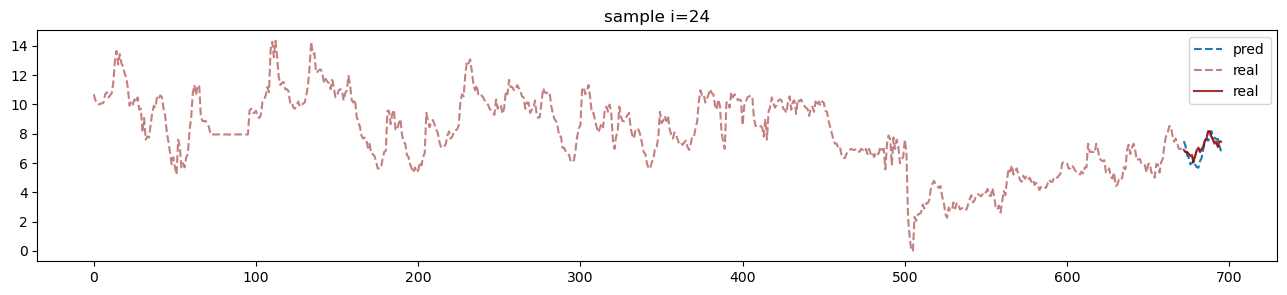

In [14]:
print(len(test_loader))
i_set = 24 #24 #48
device = cfg.device
itf_model_new.eval()
with torch.no_grad():
    for i, (batch_x, batch_y, seq_x_mark, seq_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        seq_x_mark = seq_x_mark.float().to(device)
        seq_y_mark = seq_y_mark.float().to(device)

        outputs = itf_model_new(batch_x, seq_x_mark, x_mark_dec=seq_y_mark)
        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()
        if i == i_set:
            print(i)
            break

for b in range(pred.shape[0]):
    plt.figure(figsize=(16, 3))
    back_seq = tr_data_set.inverse_transform(batch_x[b].detach().cpu().numpy())[:, -1].flatten()
    pred_ = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(pred[b].numpy())[:, -1].flatten()])
    real_only = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])
    real_ = np.concatenate([back_seq, tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])

    plt.plot(pred_, label='pred', linestyle='--')
    plt.plot(real_, label='real', linestyle='--', color='darkred', alpha=0.5)
    plt.plot(real_only, label='real', color='darkred', alpha=0.8)
    plt.legend()
    plt.title(f'sample i={i_set}')
    plt.show()
    break

# ITF add FreDF
- [FREDF: LEARNING TO FORECAST IN FREQUENCY DOMAIN](https://arxiv.org/pdf/2402.02399)

In [15]:
cfg.x_mark_dec_flag = False
cfg.learning_rate = 2.0e-5
itf_model_fredf = iTransformer(cfg)
itf_model_fredf = train(
    itf_model_fredf, tr_loader, val_loader, test_loader, cfg, invert_tf=te_data_set.inverse_transform, fft_loss_weight=1.0
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001, Steps: 249 | Train Loss: 10.25339(invLoss: 6.85503) Vali Loss: 0.63103 Test Loss: 0.38124
Saved Best Model: loss=0.63103
Epoch: 002, Steps: 249 | Train Loss: 7.75849(invLoss: 4.96375) Vali Loss: 0.55108 Test Loss: 0.35555
Saved Best Model: loss=0.55108
Epoch: 003, Steps: 249 | Train Loss: 7.09570(invLoss: 4.53680) Vali Loss: 0.51396 Test Loss: 0.34743
Saved Best Model: loss=0.51396
Epoch: 004, Steps: 249 | Train Loss: 6.68424(invLoss: 4.29705) Vali Loss: 0.50085 Test Loss: 0.34220
Saved Best Model: loss=0.50085
Epoch: 005, Steps: 249 | Train Loss: 6.37733(invLoss: 4.12628) Vali Loss: 0.49302 Test Loss: 0.34053
Saved Best Model: loss=0.49302
Epoch: 006, Steps: 249 | Train Loss: 6.07314(invLoss: 3.96783) Vali Loss: 0.47993 Test Loss: 0.33896
Saved Best Model: loss=0.47993
Epoch: 007, Steps: 249 | Train Loss: 5.76884(invLoss: 3.81767) Vali Loss: 0.48768 Test Loss: 0.34211
Epoch: 008, Steps: 249 | Train Loss: 5.46057(invLoss: 3.64606) Vali Loss: 0.48949 Test Loss: 0.34558
Epoch

90
24


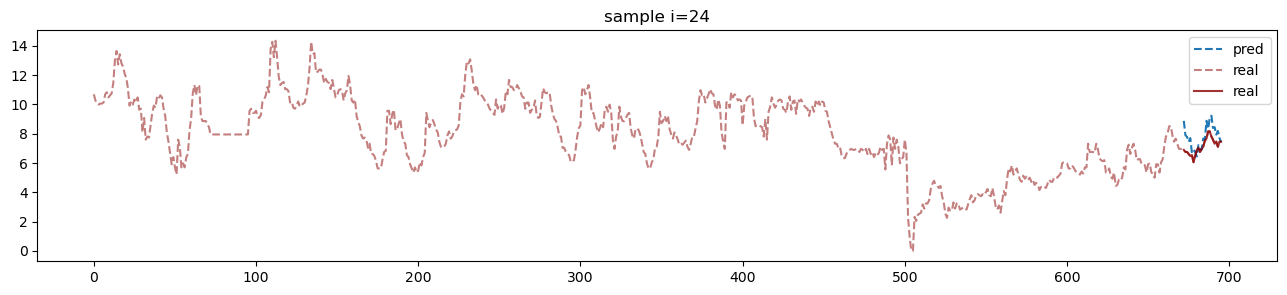

In [16]:
print(len(test_loader))
i_set = 24 #24 #48
device = cfg.device
itf_model_fredf.eval()
with torch.no_grad():
    for i, (batch_x, batch_y, seq_x_mark, seq_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        seq_x_mark = seq_x_mark.float().to(device)
        seq_y_mark = seq_y_mark.float().to(device)

        outputs = itf_model_fredf(batch_x, seq_x_mark, x_mark_dec=seq_y_mark)
        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()
        if i == i_set:
            print(i)
            break

for b in range(pred.shape[0]):
    plt.figure(figsize=(16, 3))
    back_seq = tr_data_set.inverse_transform(batch_x[b].detach().cpu().numpy())[:, -1].flatten()
    pred_ = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(pred[b].numpy())[:, -1].flatten()])
    real_only = np.concatenate([np.array([np.nan]*len(back_seq)), tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])
    real_ = np.concatenate([back_seq, tr_data_set.inverse_transform(true[b].numpy())[-cfg.pred_len:, -1].flatten()])

    plt.plot(pred_, label='pred', linestyle='--')
    plt.plot(real_, label='real', linestyle='--', color='darkred', alpha=0.5)
    plt.plot(real_only, label='real', color='darkred', alpha=0.8)
    plt.legend()
    plt.title(f'sample i={i_set}')
    plt.show()
    break